# Titanic Competition - Modeling

## 5. Modeling

**Data preparation**:
* Split train dataset into training (80%) and test (validation) (20%) sets using `train_test_split`
* Define predictive variables (X) and the target variable (y = is_canceled)
* Apply random_state=42 to ensure reproducibility

**Classification models**:
* Naive Bayes (`GaussianNB`): no hyperparameters
* K-Nearest Neighbors (`KNeighborsClassifier`): optimize `n_neighbors`
* Logistic Regression (`LogisticRegression`): optimize `C` and `max_iter`
* Linear Discriminant Analysis (`LinearDiscriminantAnalysis`): no hyperparameters
* Quadratic Discriminant Analysis (`QuadraticDiscriminantAnalysis`): no hyperparameters
* Decision Tree (`DecisionTreeClassifier`): optimize `max_depth`, `min_samples_split`, `min_samples_leaf`
* Random Forest (`RandomForestClassifier`): optimize `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`
* Suppor Vector Classifier (`SVC`): optimize `C`, `degree`

**Optimization techniques**:
* Grid Search with 5-fold cross-validation (`cv=5`)
* Optimization based on F1-score (`scoring='f1'`)
* Feature selection using Forward Selection

**Evaluation metrics**:
* Accuracy – overall correctness of classification
* Precision – quality of positive predictions
* Recall – coverage of actual positive cases
* F1-score – harmonic mean of precision and recall
* ROC-AUC – class separability
* Training time and prediction time – computational efficiency

**Process automation**:
* Systematic testing of all models across all feature combinations
* Automatic saving of results to a CSV file
* Detailed logging of progress and results for each model
* Error handling and process continuation in case of failures

### 5.1 Prepare helper functions

In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [12]:
from itertools import chain, combinations
from typing import List

def powerset(columns: List[str]) -> List[List[str]]:
    all_subsets = chain.from_iterable(
        combinations(columns, r) for r in range(1, len(columns) + 1)
    )
    
    valid_subsets = []
    for subset in all_subsets:
        subset = set(subset)
        
        # To make the process faster we will include all dummy variables if on of them appers
        if "EmbarkedA" in subset and not {"EmbarkedB", "EmbarkedC"}.issubset(subset):
            continue
        
        # To make the process faster we will include all dummy variables if on of them appers
        if "Pclass1" in subset and not {"Pclass2", "Pclass3"}.issubset(subset):
            continue
        
        valid_subsets.append(list(subset))
    
    return valid_subsets

In [13]:
models_and_params = {
    "GaussianNB": {
        "model": GaussianNB(),
        "params": {},
    },
    "KNeighborsClassifier": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7, 9],
        },
    },
    "LogisticRegression": {
        "model": LogisticRegression(),
        "params": {
            "C": [0.001, 0.01, 0.1, 1, 10, 100],
            "max_iter": [100, 200, 500, 1000]
        },
    },
    "LinearDiscriminantAnalysis": {
        "model": LinearDiscriminantAnalysis(),
        "params": {},   
    },
    "QuadraticDiscriminantAnalysis": {
        "model": QuadraticDiscriminantAnalysis(),
        "params": {},
    },
    "DecisionTreeClassifier": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        }
    },
    "RandomForestClassifier": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        },
    },
    "SVC": {
        "model": SVC(),
        "params": {
            "C": [0.1, 1, 10],
            "degree": [2, 3, 4],
        }
    }
}

In [14]:
from typing import Dict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import time

def evaluate_model(grid_search, X_test: pd.DataFrame, y_test: pd.DataFrame) -> Dict:
    print(f"\nEvaluating model: {grid_search.best_estimator_.__class__.__name__}")
    
    fit_times = grid_search.cv_results_['mean_fit_time']
    mean_fit_time = np.mean(fit_times)
    
    start_time = time.time()
    y_pred = grid_search.predict(X_test)
    predict_time = time.time() - start_time
    
    y_pred_proba = grid_search.predict_proba(X_test)[:, 1] if hasattr(grid_search, "predict_proba") else None

    metrics = {
        'accuracy': np.round(
            accuracy_score(y_test, y_pred), 4
        ),
        'precision': np.round(
            precision_score(y_test, y_pred, zero_division=0), 4
        ),
        'recall': np.round(
            recall_score(y_test, y_pred, zero_division=0), 3
        ),
        'f1': np.round(
            f1_score(y_test, y_pred, zero_division=0), 3
        ),
        'roc_auc': np.round(
            roc_auc_score(y_test, y_pred_proba), 3
        ) if y_pred_proba is not None else None,
        'mean_fit_time': np.round(
            mean_fit_time, 3
        ),
        'predict_time': np.round(
            predict_time, 3
        ),
    }
    
    print("Metrics obtained:")
    for metric, value in metrics.items():
        print(f"- {metric}: {value}")
    
    return metrics

In [15]:
from sklearn.model_selection import GridSearchCV

def evaluate_models(models_and_params: Dict, X_train: pd.DataFrame, y_train: pd.DataFrame, X_val: pd.DataFrame, y_val: pd.DataFrame) -> List:
    print(f"\nStarting evaluation of {len(models_and_params)} models")
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")
    
    results = []
    for name, info in models_and_params.items():
        print(f"\n{'='*50}")
        print(f"Training model: {name}")
        print(f"Parameter grid: {info['params']}")
        
        model = info["model"]
        params = info["params"]
        
        try:
            start_time = time.time()
            
            grid_search = GridSearchCV(
                estimator=model, 
                param_grid=params,
                cv=5,
                scoring='f1',
                n_jobs=-1,
                verbose=1,
                return_train_score=True
            )
            
            grid_search.fit(X_train, y_train)
            
            metrics = evaluate_model(grid_search, X_val, y_val)
            training_time = time.time() - start_time
            
            print(f"Best parameters found: {grid_search.best_params_}")
            print(f"Training time: {training_time:.2f} seconds")
            
            result = {
                'model': name,
                'columns': X_train.columns.tolist(),
                'best_params': str(grid_search.best_params_),
                'training_time': training_time,
                **metrics
            }
            results.append(result)
            
            
        except Exception as e:
            print(f"Error training {name}: {str(e)}")
    
    return results

In [16]:
def prepare_evalution(models_and_params: Dict, columns: List[str], X_train: pd.DataFrame, y_train: pd.DataFrame, X_val: pd.DataFrame, y_val: pd.DataFrame) -> pd.DataFrame:
    results = []
    total_combinations = len(list(powerset(columns)))
    
    print(f"Starting evaluation with {len(columns)} features")
    print(f"Total feature combinations to evaluate: {total_combinations}")
    
    for i, cols in enumerate(tqdm(powerset(columns)), 1):
        
        print(f"\nEvaluating combination {i}/{total_combinations}")
        print(f"Selected features: {cols}")
        
        X_train_sub = X_train[list(cols)]
        X_val_sub = X_val[list(cols)]
        
        results.append(
            evaluate_models(models_and_params, X_train_sub, y_train, X_val_sub, y_val)
        )
        
        print(f"Completed combination {i}/{total_combinations}")
    
    print("\nCreating results DataFrame...")
    results_list = [pd.DataFrame(result) for result in results]
    results_df = pd.concat(results_list, ignore_index=True).reset_index(drop=True)
    
    print("Saving results to CSV...")
    results_df.to_csv("data/train_results.csv")
    
    print("Evaluation complete!")
    
    return results_df


### 5.2 Prepare data

In [17]:
train_clean = pd.read_csv("data/train_clean.csv")
train_clean.head()

,Survived,Sex,Age,Fare,EmbarkedC,EmbarkedQ,EmbarkedS,Pclass1,Pclass2,Pclass3
0,0,1,-0.532730,-0.500240,0,0,1,0,0,1
1,1,0,0.673661,0.788947,1,0,0,1,0,0
2,1,0,-0.231132,-0.486650,0,0,1,0,0,1
3,1,0,0.447463,0.422861,0,0,1,1,0,0
4,0,1,0.447463,-0.484133,0,0,1,0,0,1


In [18]:
from sklearn.model_selection import train_test_split

X = train_clean.drop(columns=["Survived"])
y = train_clean["Survived"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
columns = X.columns.to_list()
columns

['Sex',
 'Age',
 'Fare',
 'EmbarkedC',
 'EmbarkedQ',
 'EmbarkedS',
 'Pclass1',
 'Pclass2',
 'Pclass3']

### 5.3 Modeling

In [20]:
results = prepare_evalution(
    models_and_params, 
    columns, 
    X_train, 
    y_train, 
    X_val, 
    y_val
)

Starting evaluation with 9 features
Total feature combinations to evaluate: 319


  0%|          | 0/319 [00:00<?, ?it/s]


Evaluating combination 1/319
Selected features: ['Sex']

Starting evaluation of 8 models
Training data shape: (711, 1)
Validation data shape: (178, 1)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: GaussianNB
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.792
- mean_fit_time: 0.003
- predict_time: 0.002
Best parameters found: {}
Training time: 2.53 seconds

Training model: KNeighborsClassifier
Parameter grid: {'n_neighbors': [3, 5, 7, 9]}
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Evaluating model: KNeighborsClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.792
- mean_fit_time: 0.003
- predict_time: 0.01
Best parameters found: {'n_neighbors': 9}
Training time: 2.48 seconds

Training model: LogisticRegression
Parameter grid: {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [100, 200, 

  0%|          | 1/319 [00:34<3:03:47, 34.68s/it]


Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.009
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.26 seconds
Completed combination 1/319

Evaluating combination 2/319
Selected features: ['Age']

Starting evaluation of 8 models
Training data shape: (711, 1)
Validation data shape: (178, 1)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: GaussianNB
Metrics obtained:
- accuracy: 0.6067
- precision: 0.4
- recall: 0.029
- f1: 0.054
- roc_auc: 0.467
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {}
Training time: 0.10 seconds

Training model: KNeighborsClassifier
Parameter grid: {'n_neighbors': [3, 5, 7, 9]}
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Evaluating model: KNeighborsClassifier
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5179
- 

  0%|          | 1/319 [00:53<4:41:35, 53.13s/it]


KeyboardInterrupt: 

## 6. Evaluation

In [22]:
import pandas as pd
results = pd.read_csv("data/train_results.csv", index_col=[0])

In [26]:
len(results)

2233

In [41]:
print(f"Number of models with f1-score higher or equalt to 0.7: {len(results[(results['f1'] >= 0.7)])}")

Number of models with f1-score higher or equalt to 0.7: 1017


In [42]:
print(f"Number of models with f1-score higher or equalt to 0.75: {len(results[(results['f1'] >= 0.75)])}")

Number of models with f1-score higher or equalt to 0.75: 398


In [43]:
print(f"Number of models with f1-score higher or equalt to 0.78: {len(results[(results['f1'] >= 0.78)])}")

Number of models with f1-score higher or equalt to 0.78: 27


In [40]:
results[
    (results['f1'] > 0.78)
].sort_values(by=['f1'], ascending=False).head(25)

,model,columns,best_params,training_time,accuracy,precision,recall,f1,roc_auc,mean_fit_time,predict_time
755,RandomForestClassifier,"['Sex', 'Age', 'Pclass3', 'Pclass2']","{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",9.700509,0.8483,0.8387,0.754,0.794,0.866,0.305,0.007
1226,KNeighborsClassifier,"['Pclass3', 'Sex', 'EmbarkedQ', 'Age', 'Fare']",{'n_neighbors': 5},0.042931,0.8427,0.8060,0.783,0.794,0.866,0.002,0.002
2059,KNeighborsClassifier,"['Pclass2', 'Pclass3', 'Sex', 'EmbarkedQ', 'Ag...",{'n_neighbors': 5},0.053519,0.8371,0.7857,0.797,0.791,0.873,0.002,0.002
1737,KNeighborsClassifier,"['Pclass2', 'Pclass3', 'Sex', 'EmbarkedQ', 'Ag...",{'n_neighbors': 5},0.053026,0.8371,0.7857,0.797,0.791,0.873,0.002,0.002
2197,RandomForestClassifier,"['Pclass2', 'Pclass3', 'Sex', 'EmbarkedS', 'Ag...","{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",10.047830,0.8315,0.7671,0.812,0.789,0.880,0.314,0.007
258,RandomForestClassifier,"['Sex', 'Fare', 'Age']","{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",18.635312,0.8315,0.7671,0.812,0.789,0.864,0.595,0.006
2232,RandomForestClassifier,"['Pclass2', 'Pclass3', 'EmbarkedQ', 'Sex', 'Em...","{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",10.170662,0.8371,0.7941,0.783,0.788,0.882,0.325,0.004
2071,RandomForestClassifier,"['Pclass2', 'Pclass3', 'Sex', 'EmbarkedS', 'Ag...","{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",9.851263,0.8427,0.8254,0.754,0.788,0.875,0.313,0.004
1805,RandomForestClassifier,"['Pclass2', 'Pclass3', 'Sex', 'EmbarkedQ', 'Ag...","{'max_depth': 30, 'min_samples_leaf': 2, 'min_...",9.788568,0.8427,0.8254,0.754,0.788,0.879,0.306,0.010
267,KNeighborsClassifier,"['Sex', 'Age', 'EmbarkedQ']",{'n_neighbors': 9},0.143936,0.8258,0.7500,0.826,0.786,0.840,0.002,0.003


### 6.1 Visualization

In [44]:

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

plt.style.use('ggplot')

def visualize_results(df: pd.DataFrame):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'training_time', 'predict_time']
    
    for metric in metrics:
        plt.figure(figsize=(12, 8))

        ax = sns.boxplot(x='model', y=metric, data=df, palette='viridis', hue='model')
        
        plt.title(f'{metric.replace("_", " ").title()} by Model', fontsize=16)
        plt.xlabel('Model', fontsize=14)
        plt.ylabel(f'{metric.replace("_", " ").title()}', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        plt.show()

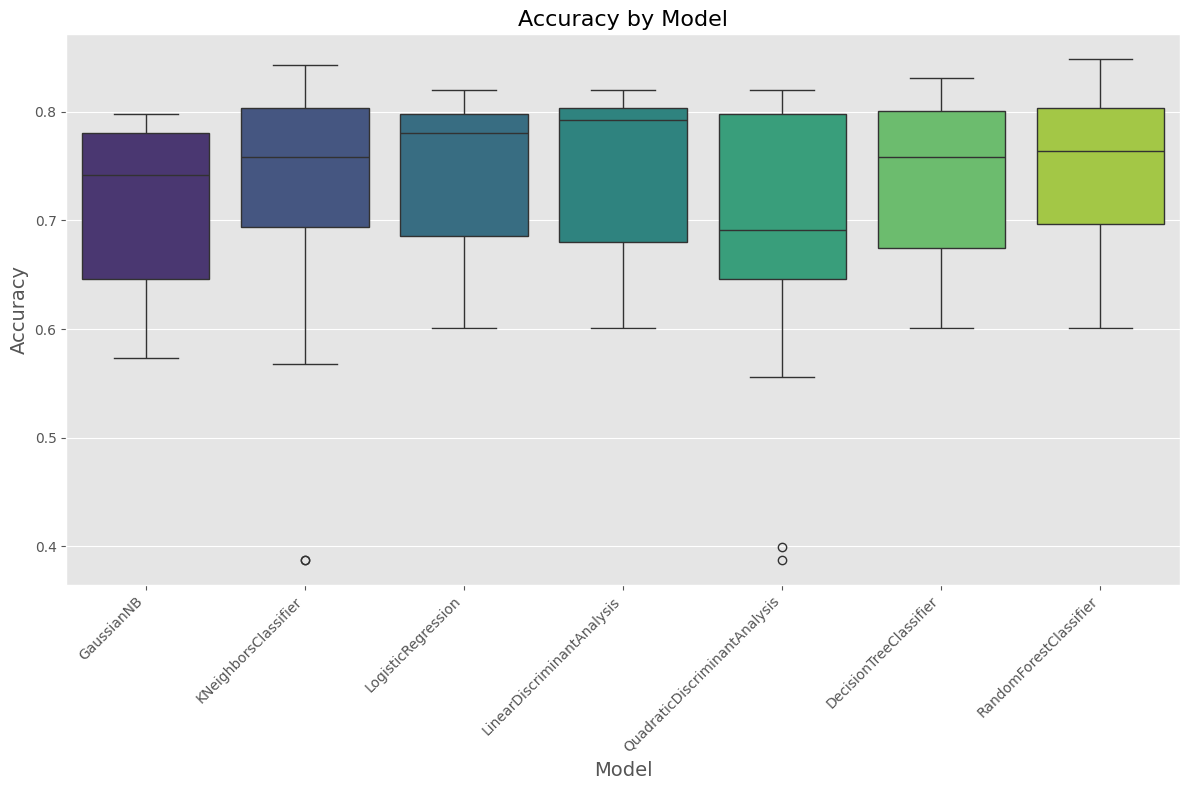

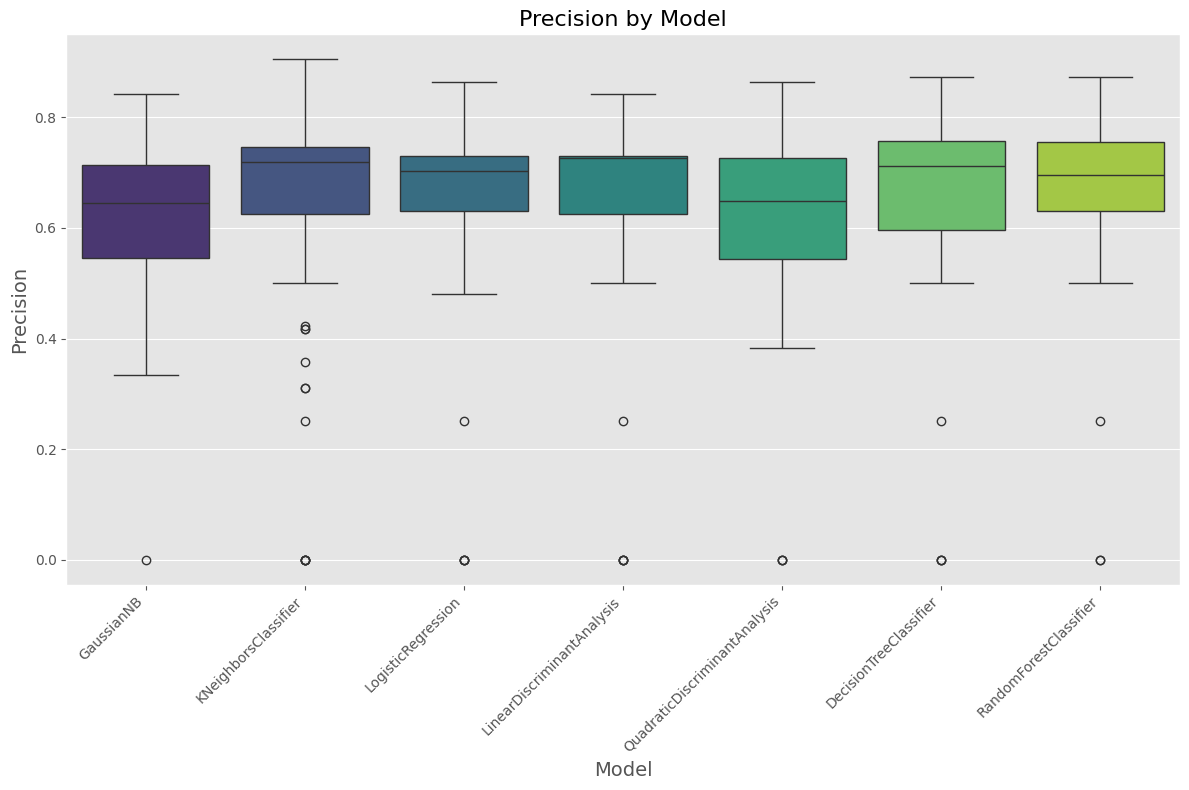

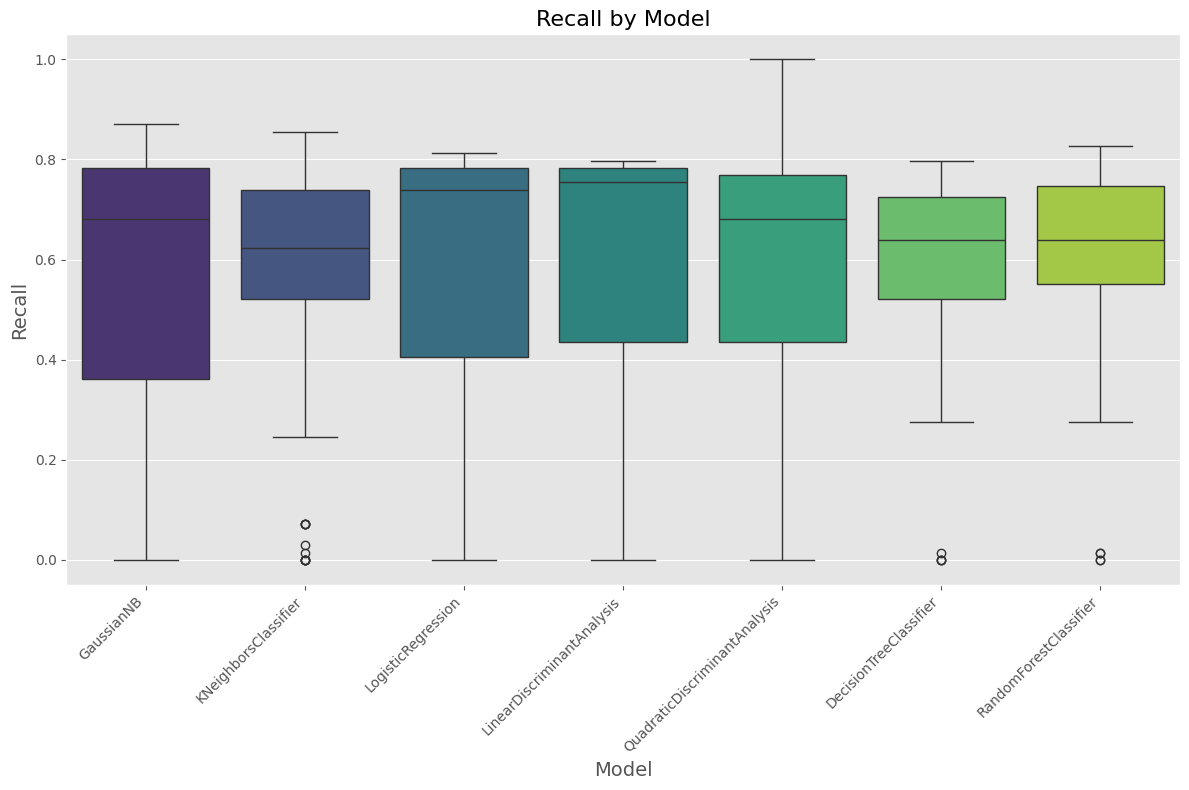

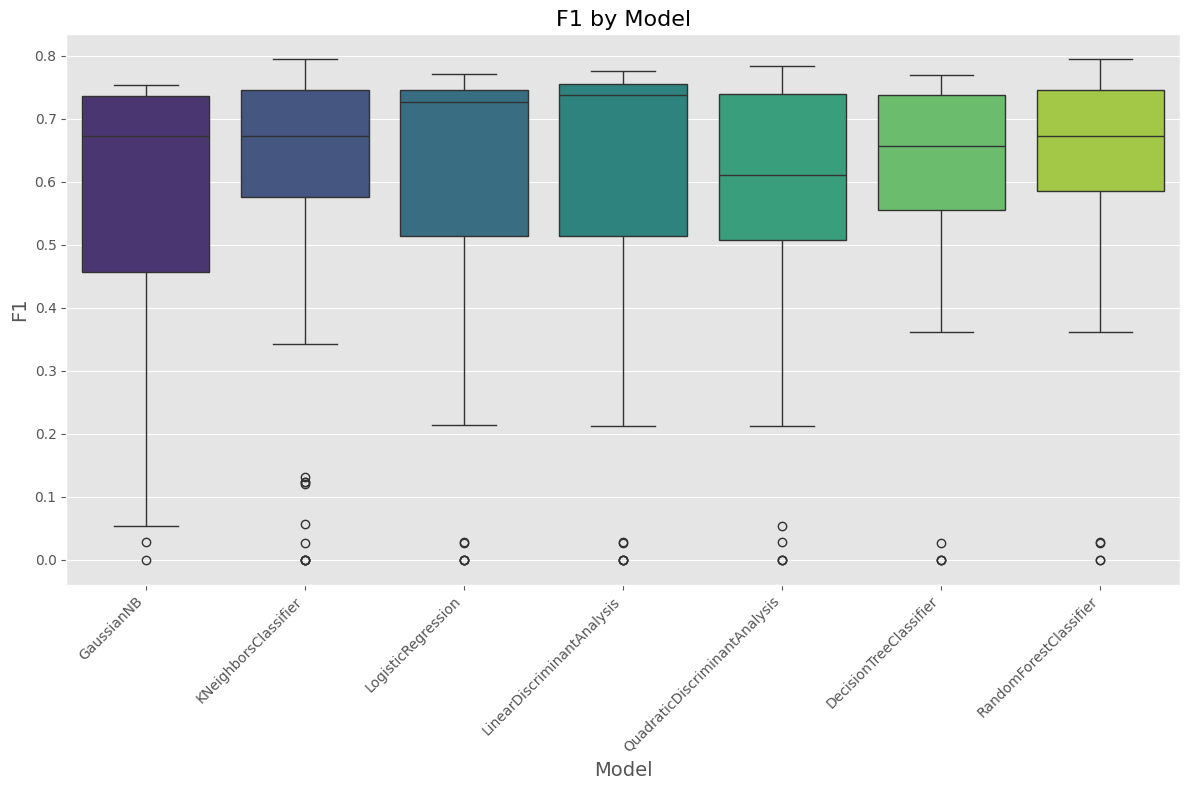

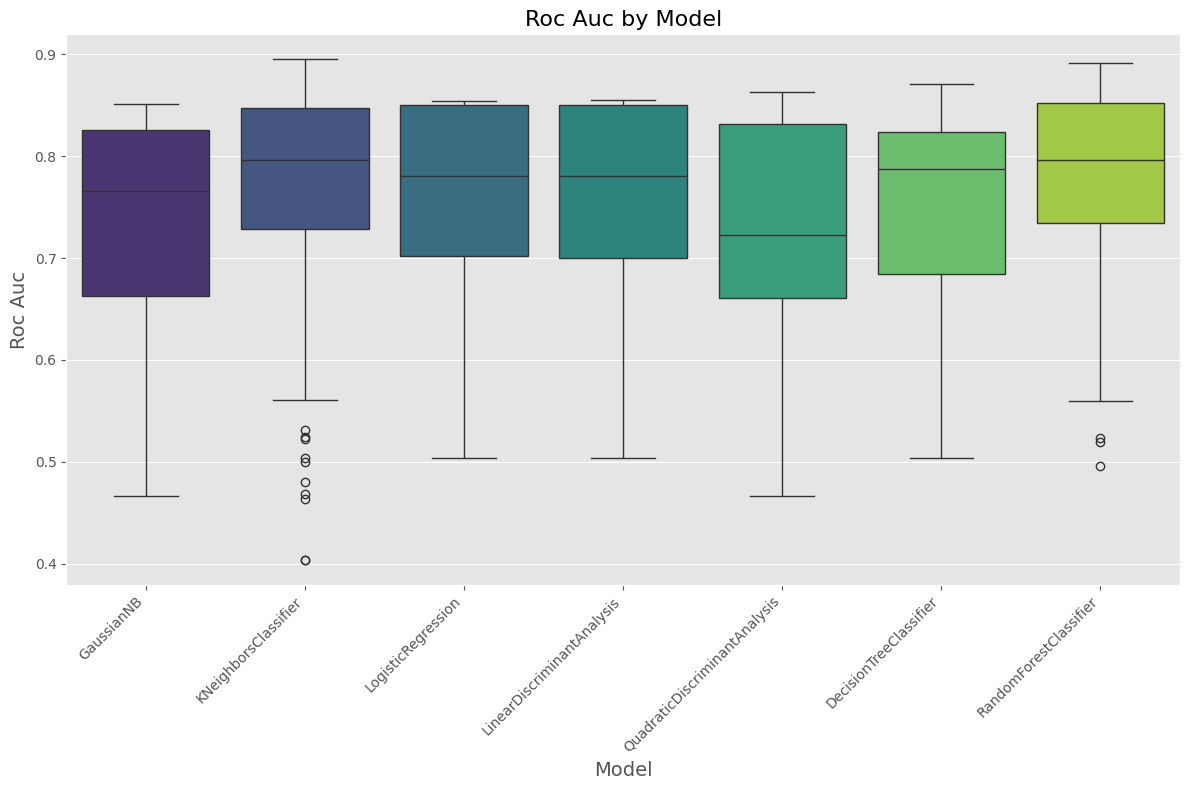

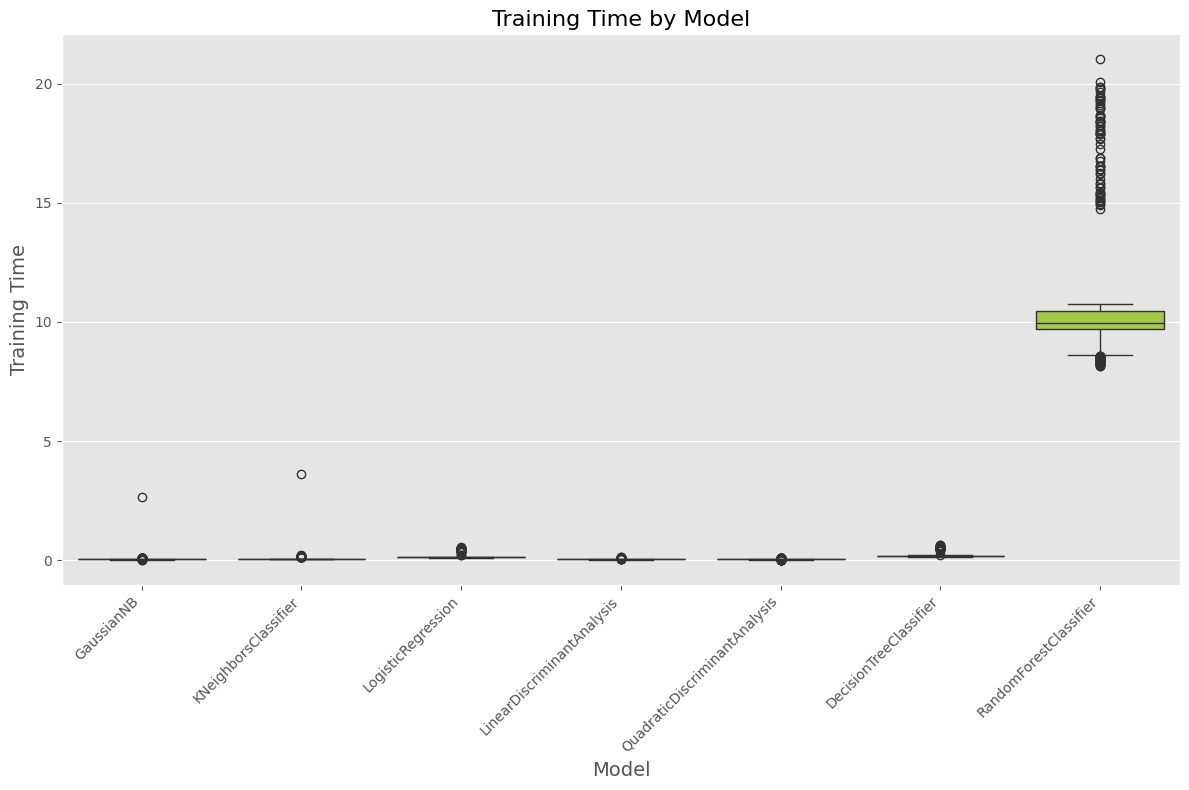

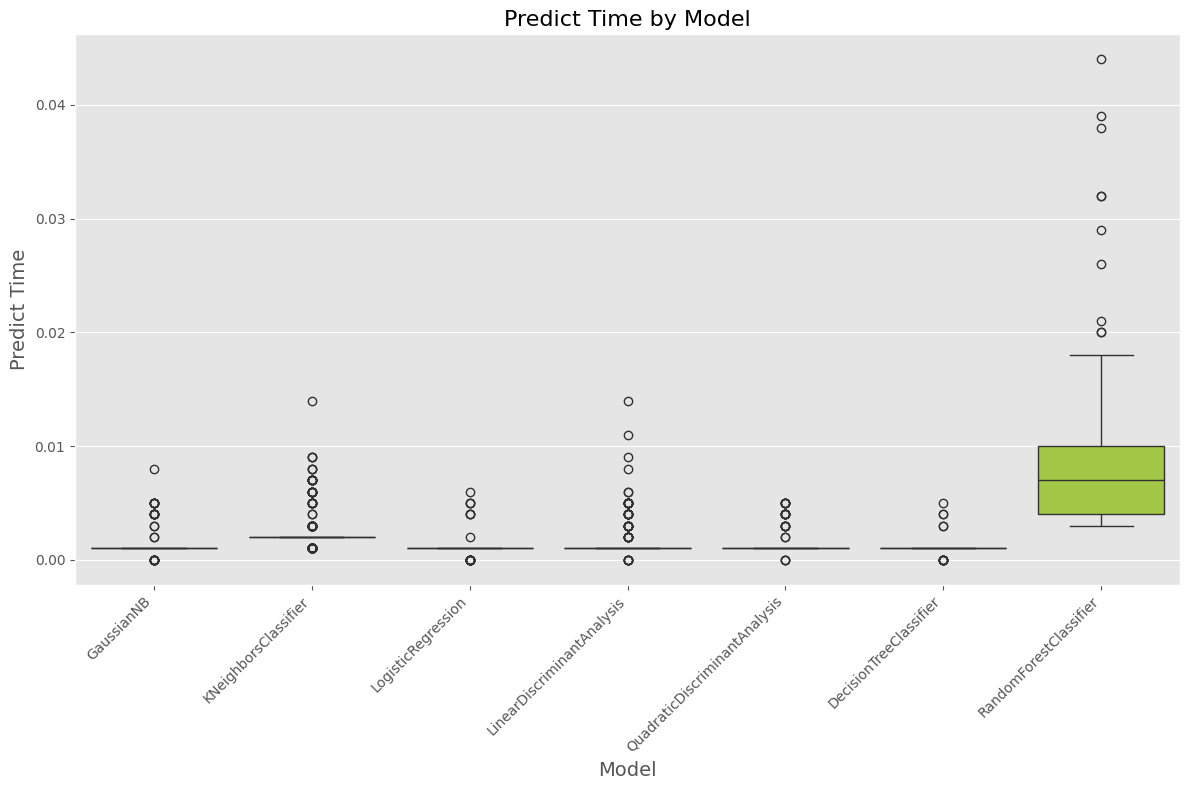

In [45]:
visualize_results(results)

## 7. Findings

Best models created for this tasks are Random Forest Classifier and K-Nearest Neighbours

As their f1-score, precision, recall, and accuracy are quite the same I decided to choose as a final model K-Nearest Neighbours with 5 number of neighbros and classifing on `Pclass3`, `Sex`, `EmbarkedQ`, `Age`, `Fare` columns

KNN algorithm showed outclassified Random Forest Classifier in case of training and testing time

In [46]:
best_model = KNeighborsClassifier(
    n_neighbors=5
)

In [67]:
X_train, y_train = train_clean.drop(["Survived"], axis=1), train_clean["Survived"]

In [69]:
best_model.fit(X=X_train, y=y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


## 8. Make predictions

To make proper classification test set needs to be transformed:
* `Age` must be filled out with median value from trainig set
* `Embarked`, `Pclass` must be  codded as dummy variable
* `Sex` must be coded as 0 for female and 1 for male
* `Age` and `Fare` must be scaled with `sklearn.preprocessing.StandardScaler`

Final columns are: `Pclass3`, `Sex`, `EmbarkedQ`, `Age`, `Fare`

**Results** on new and unseen data: 
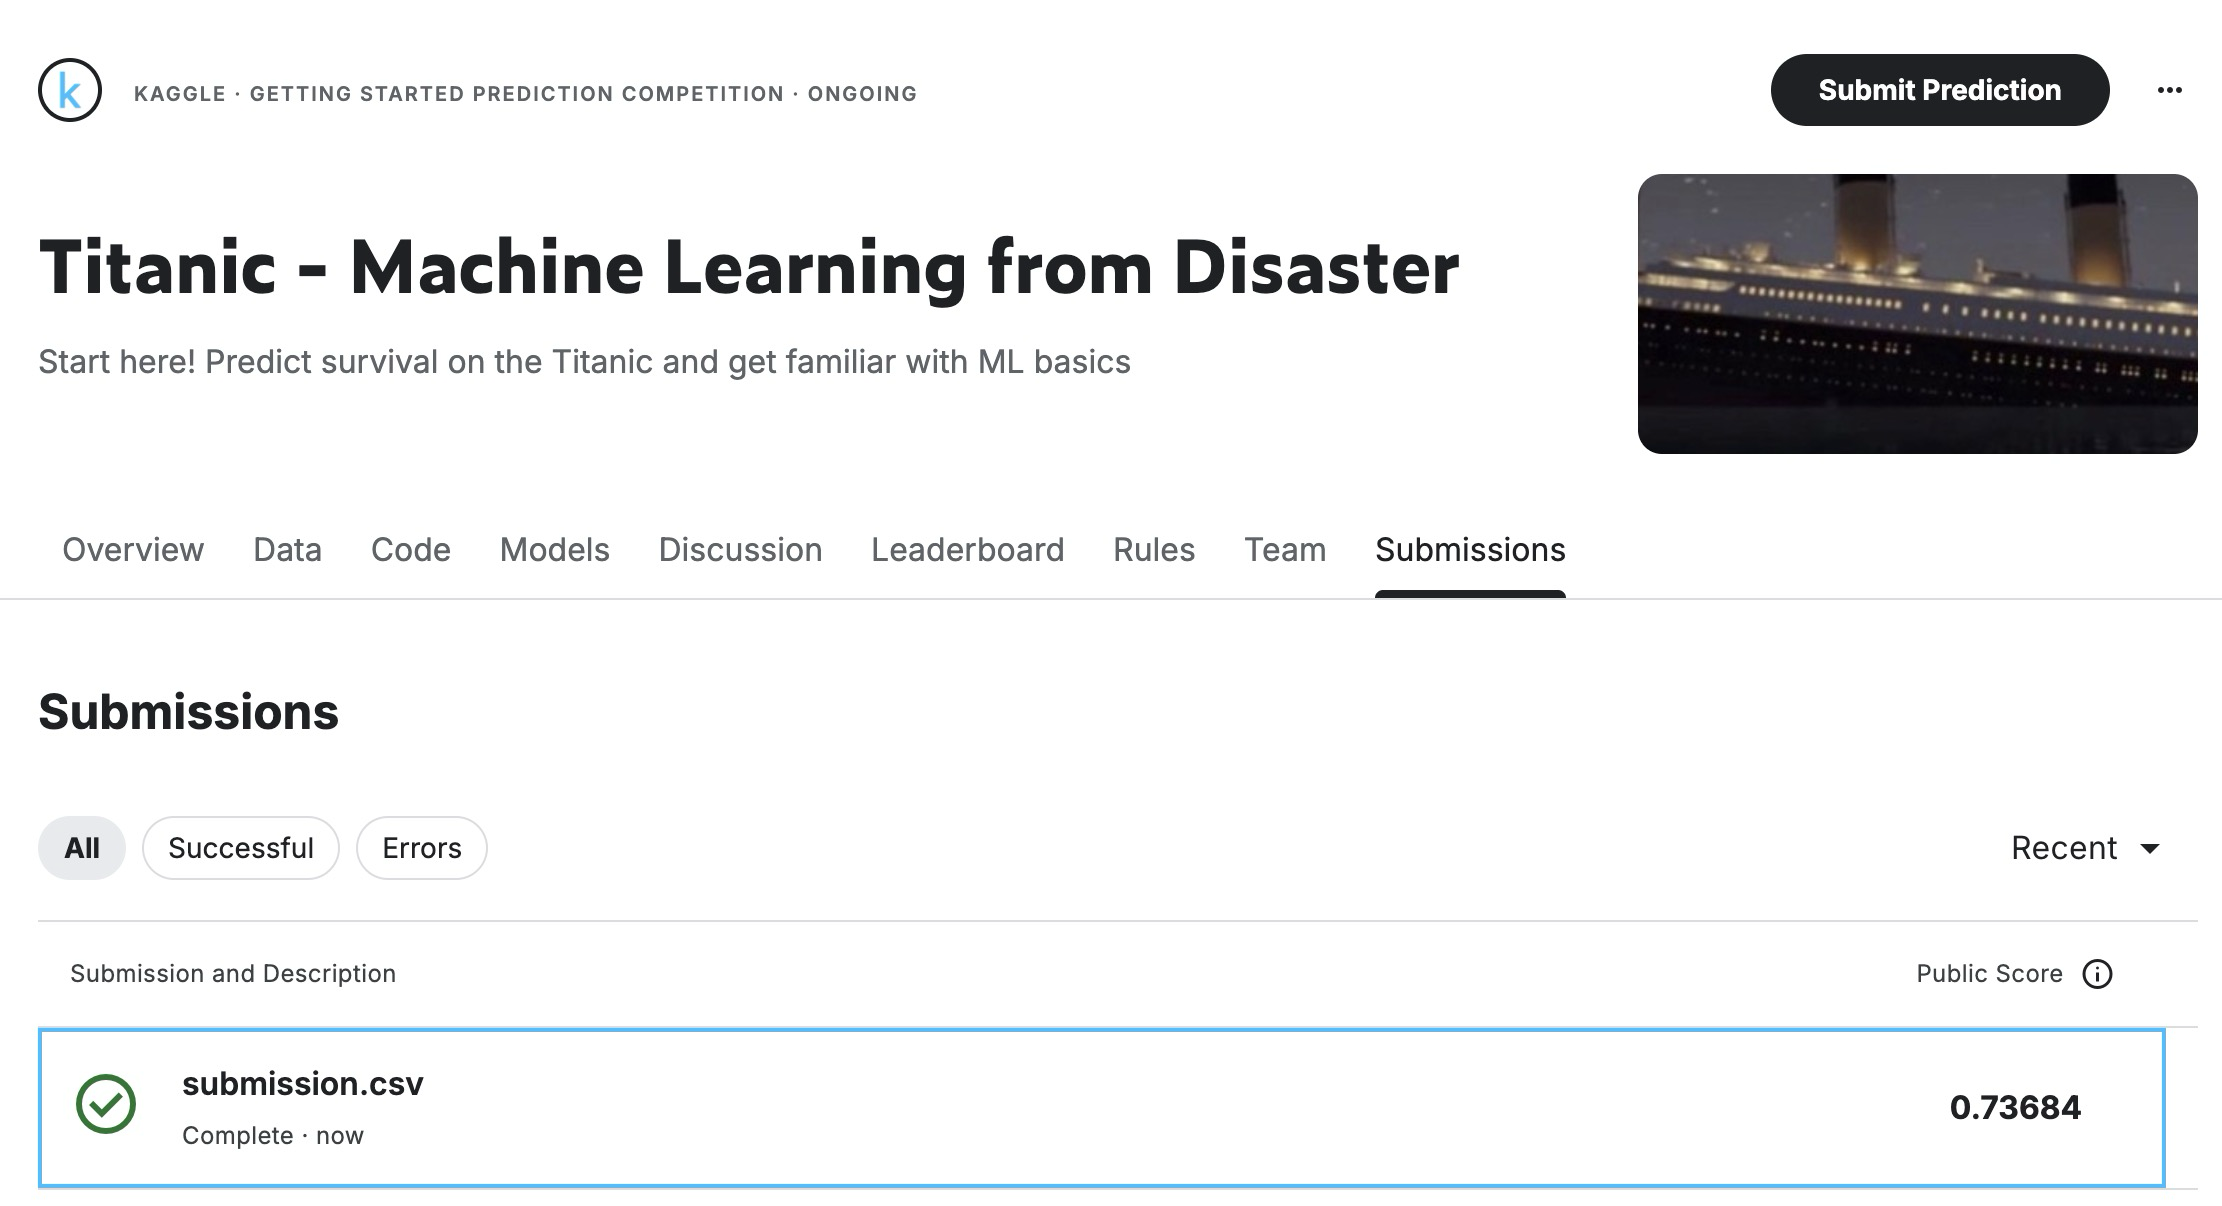

In [102]:
titatnic_test = pd.read_csv("data/test.csv")

In [103]:
titatnic_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### 8.1 Data preparation

In [104]:
test_clean = titatnic_test[
    ["Pclass", "Sex", "Age", "Fare", "Embarked", "SibSp", "Parch"]
]

In [105]:
GROUP_MEDIAN = pd.read_csv("data/train.csv").groupby(["Sex", "Pclass"])["Age"].median()

def fill_age(row):
    if pd.isnull(row["Age"]):
        return GROUP_MEDIAN.loc[row["Sex"], row["Pclass"]]
    else:
        return row["Age"]

test_clean["Age"] = test_clean.apply(fill_age, axis=1)

/var/folders/hz/kv51gkp17hd22cn05cv5whww0000gn/T/ipykernel_32241/1020817331.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean["Age"] = test_clean.apply(fill_age, axis=1)


In [106]:
GROUP_MEDIAN = pd.read_csv("data/train.csv").groupby(["Sex", "Pclass"])["Fare"].median()

def fill_age(row):
    if pd.isnull(row["Fare"]):
        return GROUP_MEDIAN.loc[row["Sex"], row["Pclass"]]
    else:
        return row["Fare"]

test_clean["Fare"] = test_clean.apply(fill_age, axis=1)

/var/folders/hz/kv51gkp17hd22cn05cv5whww0000gn/T/ipykernel_32241/3619910836.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean["Fare"] = test_clean.apply(fill_age, axis=1)


In [107]:
embarked = pd.get_dummies(
    data=test_clean["Embarked"],
    prefix="Embarked",
    prefix_sep="",
    drop_first=False
).astype(int)

test_clean[["EmbarkedC", "EmbarkedQ", "EmbarkedS"]] = embarked

/var/folders/hz/kv51gkp17hd22cn05cv5whww0000gn/T/ipykernel_32241/1934814547.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean[["EmbarkedC", "EmbarkedQ", "EmbarkedS"]] = embarked
/var/folders/hz/kv51gkp17hd22cn05cv5whww0000gn/T/ipykernel_32241/1934814547.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean[["EmbarkedC", "EmbarkedQ", "EmbarkedS"]] = embarked
/var/folders/hz/kv51gkp17hd22cn05cv5whww0000gn/T/ipykernel_32241/1934814547.py:8: SettingWithCopyWarning: 
A value is trying to be

In [108]:
test_clean["Sex"] = test_clean["Sex"].map(
    lambda x: 1 if x == "male" else 0
)

/var/folders/hz/kv51gkp17hd22cn05cv5whww0000gn/T/ipykernel_32241/3965721011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean["Sex"] = test_clean["Sex"].map(


In [109]:
pclass = pd.get_dummies(
    data=test_clean["Pclass"],
    prefix="Pclass",
    prefix_sep="",
    drop_first=False
).astype(int)

test_clean[["Pclass1", "Pclass2", "Pclass3"]] = pclass

In [110]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

test_clean["Age"] = scaler.fit_transform(test_clean[["Age"]])
test_clean["Fare"] = scaler.fit_transform(test_clean[["Fare"]])

In [111]:
test_clean.columns

Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'SibSp', 'Parch',
       'EmbarkedC', 'EmbarkedQ', 'EmbarkedS', 'Pclass1', 'Pclass2', 'Pclass3'],
      dtype='object')

In [112]:
test_clean = test_clean[
    ['Sex', 'Age', 'Fare', 'EmbarkedC', 'EmbarkedQ', 'EmbarkedS', 'Pclass1', 'Pclass2', 'Pclass3']
]

In [113]:
test_clean.isna().sum()

Sex          0
Age          0
Fare         0
EmbarkedC    0
EmbarkedQ    0
EmbarkedS    0
Pclass1      0
Pclass2      0
Pclass3      0
dtype: int64

In [114]:
test_clean.head()

,Sex,Age,Fare,EmbarkedC,EmbarkedQ,EmbarkedS,Pclass1,Pclass2,Pclass3
0,1,0.397341,-0.497072,0,1,0,0,0,1
1,0,1.363196,-0.511935,0,0,1,0,0,1
2,1,2.522221,-0.463764,0,1,0,0,1,0
3,1,-0.182172,-0.482136,0,0,1,0,0,1
4,0,-0.568514,-0.417160,0,0,1,0,0,1


### 8.2 Prediction

In [116]:
y_pred = best_model.predict(
    test_clean
)

### 8.3 Prepare submission file

In [119]:
y_pred = pd.Series(y_pred, name="Survived")

In [120]:
titatnic_test = pd.concat(
    [titatnic_test, y_pred],
    axis=1
)

In [121]:
titatnic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


In [122]:
submission = titatnic_test[["PassengerId", "Survived"]]

In [123]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0


In [125]:
submission.to_csv("data/submission.csv", index=False)